# Climate Analysis - Hawaii
---
### Dependencies

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

In [4]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

### Reflect Tables into SQLAlchemy ORM

In [5]:
# Source based on local sqlite file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Connect to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Explore the structure of the Measurement db
test = session.query(Measurement).first()
test.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x24783873080>,
 'prcp': 0.08,
 'date': '2010-01-01',
 'id': 1,
 'tobs': 65.0,
 'station': 'USC00519397'}

In [11]:
# Find the range of the data
last = session.query(Measurement).order_by(Measurement.date.desc()).first()
last.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x24783873630>,
 'prcp': 0.0,
 'date': '2017-08-23',
 'id': 2724,
 'tobs': 81.0,
 'station': 'USC00519397'}

In [12]:
# Query the last year's worth of records
target_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
last_yr_q = session.query(Measurement).filter(Measurement.date > target_date).order_by(Measurement.date, Measurement.tobs)

In [13]:
# Store the results into a dataframe for manipulation
weather_df = pd.read_sql(last_yr_q.statement, session.bind)
weather_df.count()

id         2223
station    2223
date       2223
prcp       2015
tobs       2223
dtype: int64

In [14]:
# Extract just the precipitation values
prcp_df = weather_df[['date', 'prcp']]

# Rename the column for readability
prcp_df.columns = ['Date', 'Precipitation']

# Set the index for easier plotting
prcp_df.set_index('Date', inplace=True)
prcp_df.head()

,Precipitation
Date,
2016-08-24,1.45
2016-08-24,2.15
2016-08-24,2.15
2016-08-24,NaN
2016-08-24,0.08


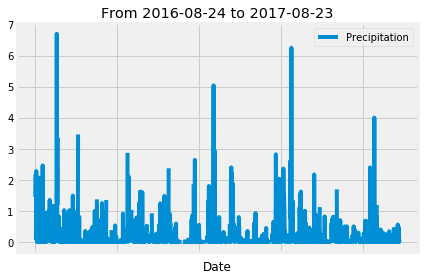

In [15]:
# Simple plot of precipitation over the last year of available data
prcp_plt = prcp_df.plot(title=(f"From {target_date + dt.timedelta(days=1)} to {last.date}"))
plt.tight_layout()
plt.show()

In [16]:
# Summary of precipitation findings for the last year's worth of data
prcp_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


---

In [17]:
# Determine the number of unique station id's in the dataset
stations = session.query(Measurement.station).distinct()
stations.count()

9

In [18]:
# Get a count of records for each station id in descending order
station_cts = session.query(Measurement.station, func.count(Measurement.date)).\
    group_by(Measurement.station).order_by(func.count(Measurement.date).desc())
station_cts.all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Get min/max/avg data from the station with the most observations
summ_most_obs_q = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station=='USC00519281')
summ_most_obs_q.all()

[(54.0, 85.0, 71.66378066378067)]

In [20]:
# Get the last year's worth of the data related to that particular station
most_obs_q = session.query(Measurement).filter(Measurement.date > target_date).\
    filter(Measurement.station=='USC00519281').order_by(Measurement.date)
most_obs_df = pd.read_sql_query(most_obs_q.statement, session.bind)

# Display results
most_obs_df.head()

,id,station,date,prcp,tobs
0,14609,USC00519281,2016-08-24,2.15,77.0
1,14610,USC00519281,2016-08-25,0.06,80.0
2,14611,USC00519281,2016-08-26,0.01,80.0
3,14612,USC00519281,2016-08-27,0.12,75.0
4,14613,USC00519281,2016-08-28,0.60,73.0


In [21]:
# Extract just the temperature data
mo_temps_df = most_obs_df[["date", "tobs"]]
mo_temps_df.columns = ["Date", "Temp. Observed"]
mo_temps_df.set_index("Date", inplace=True)
mo_temps_df.head()

,Temp. Observed
Date,
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
2016-08-28,73.0


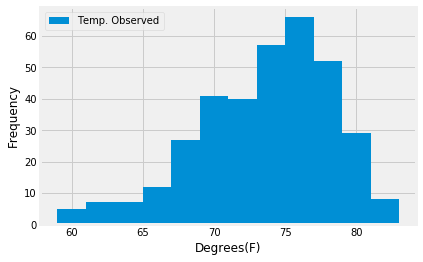

In [22]:
# Visualize with a histogram
mo_hist = mo_temps_df.plot.hist(bins=12)
xlbl = plt.xlabel("Degrees(F)")

---

In [23]:
# Function to accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()[0]

In [24]:
# Find the temp lo's, hi's and avg for the same time 2 years ago
# Set start and end dates
start = dt.date(2017,7,15)
end = dt.date(2017,7,19)
start_dt = start.strftime("%Y-%m-%d")
end_dt = end.strftime("%Y-%m-%d")
# Find matching data
lo, av, hi = calc_temps(start_dt, end_dt)

print(f"Low:{lo} Highs:{hi} Avg:{av}")

Low:72.0 Highs:83.0 Avg:78.74193548387096


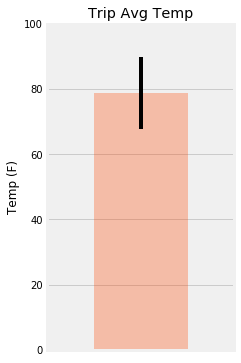

In [25]:
# Graphical representation of results
yerr = hi - lo
x = [1]
y = [av]

fig, ax = plt.subplots(figsize=(3, 6))
tat_plt = plt.bar(x, y, color='orangered', yerr=yerr, width=1, alpha=.3)

# Tweak graph appearance
tp = plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
grid = plt.grid(axis='x', which='both')
ylim = plt.ylim(0, 100)
xlim = plt.xlim(0, 2)
title = plt.title("Trip Avg Temp")
ylbl = plt.ylabel("Temp (F)")
plt.show()

In [26]:
# Inspect 'station' type to find matching param to 'measurement'
inspector = inspect(engine)
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [27]:
# Calculate the total rainfall per weather station along with weatherstation info
by_station_q = session.query(Station, func.sum(Measurement.prcp).label('total_rainfall')).\
    filter(Measurement.station==Station.station).\
    filter(Measurement.date>=start_dt).filter(Measurement.date<=end_dt).group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc())
by_station_df = pd.read_sql_query(by_station_q.statement, session.bind)

# Drop the id column - shorter to drop here than specify in query
by_station_df = by_station_df.drop(columns=["id"])

# Display results
by_station_df

,station,name,latitude,longitude,elevation,total_rainfall
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,3.66
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.46
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.38
3,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.25
4,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.10
5,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.00
6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.00


---
### Historical Temperature Patterns

In [28]:
# Function to create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()[0]


In [29]:
# Create a list of days to represent trip duration (2 years ago)
trip_dates = [start + dt.timedelta(days=i) for i in range(0, ((end-start).days + 1))]

# Extract just the month and day for daily_normals function
td_str = [i.strftime("%m-%d") for i in trip_dates]

# Collect a list of the normal's values for the trip
normals = []
for i in td_str:
    normals.append(daily_normals(i))

# Preview results
normals

[(68.0, 76.2542372881356, 82.0),
 (70.0, 76.34482758620689, 83.0),
 (70.0, 76.30188679245283, 83.0),
 (72.0, 76.63793103448276, 83.0),
 (68.0, 75.89090909090909, 83.0)]

In [30]:
# Format results as a dataframe
norms_df = pd.DataFrame(normals, columns=["tMin", "tAvg", "tMax"])

# Add dates and set as index
norms_df["date"] = trip_dates
norms_df.set_index("date", inplace=True)

# Display Results
norms_df

,tMin,tAvg,tMax
date,,,
2017-07-15,68.0,76.254237,82.0
2017-07-16,70.0,76.344828,83.0
2017-07-17,70.0,76.301887,83.0
2017-07-18,72.0,76.637931,83.0
2017-07-19,68.0,75.890909,83.0


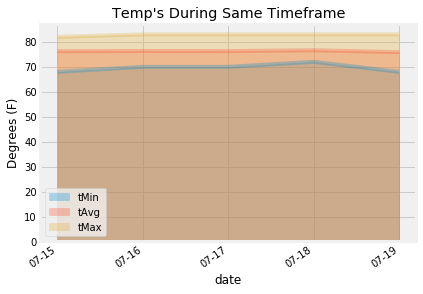

In [31]:
# Visualize results with an area plot
norms_df.plot.area(stacked=False, alpha=.3)

# Adjust labels
ymds = [i.strftime("%Y-%m-%d") for i in trip_dates]
xticks = plt.xticks(trip_dates, td_str, rotation=35, horizontalalignment="right")
ylabel = plt.ylabel("Degrees (F)")
title = plt.title("Temp's During Same Timeframe")

plt.show()